In [73]:
import numpy as np
import pandas as pd
import cv2
import time
import matplotlib.pyplot as plt


# page 500 from theodories book

In [74]:
def distance(ref,test,i,j) :
    ref_height, ref_width = ref.shape
    test = test[i:i+ref_height,j:j+ref_width].astype(np.int64)

    ans = np.absolute(ref.astype(np.int64) - test)
    ans = ans * ans

    return np.sum(ans)


def export_video(all_frames,fps,Width,Height) :

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi',fourcc,fps,(Width,Height))

    for i in range(len(all_frames)) :
        out.write(all_frames[i])
    
    out.release()
    print('Video exported!')



def exhaustive_search(ref,frames,fps,p) :
    start = time.time()
    ref_height, ref_width  = ref.shape
    test_height, test_width,  = frames[0].shape
    
    search = 0
    num_of_frames = len(frames)
    output_frames = []
    prevI = 0
    prevJ = 0

    for frame in range(num_of_frames) :

        if frame == 0 :
            startI = 0
            startJ = 0
            endI = test_height - ref_height + 1
            endJ = test_width - ref_width + 1
        else :
            startI = prevI - p
            startJ = prevJ - p
            endI = prevI + p
            endJ = prevJ + p


        min_dist = 10000000000
        minI = 0
        minJ = 0
        for i in range(startI,endI) :
            for j in range(startJ,endJ) :

                # sanity check
                if i < 0 or j < 0 or i + ref_height > test_height or j + ref_width > test_width :
                    continue
    
                search += 1
                dist = distance(ref,frames[frame],i,j)
                if dist < min_dist :
                    min_dist = dist
                    minI = i
                    minJ = j
        
        rect_img = cv2.cvtColor(frames[frame], cv2.COLOR_GRAY2BGR)
        cv2.rectangle(rect_img,(minJ,minI),(minJ+ref_width,minI+ref_height),(0,0,255),2)
        output_frames.append(rect_img)

        prevI = minI
        prevJ = minJ

    end = time.time()
    duration = end - start
    avg_search = search / num_of_frames

    # print('Exhaustive search took {} seconds'.format(duration))
    # print('Searching {} times'.format(search))
    # export_video(output_frames,fps,test_width,test_height)

    return duration, avg_search




        

def logarithmic_search(ref,frames,fps,p) :
    start = time.time()
    ref_height, ref_width  = ref.shape
    test_height, test_width,  = frames[0].shape
    search = 0
    num_of_frames = len(frames)
    output_frames = []
    prevI = 0
    prevJ = 0

    for frame in range(num_of_frames) :
        min_distance = 10000000000
        minI = 0
        minJ = 0

        if frame == 0 :
            for i in range(test_height - ref_height + 1) :
                for j in range(test_width - ref_width + 1) :

                    # sanity check
                    if i < 0 or j < 0 or i + ref_height > test_height or j + ref_width > test_width :
                        continue

                    search += 1
                    dist = distance(ref,frames[frame],i,j)
                    if dist < min_distance :
                        min_distance = dist
                        minI = i
                        minJ = j
        
        else :
            
            temP = p
            while True:
                k = np.ceil(np.log2(temP))
                d = int(2**(k-1))

                if d < 1 :
                    break
                    
                min_distance = 10000000000
                minI = 0
                minJ = 0

                II = [prevI - d, prevI, prevI + d]
                JJ = [prevJ - d, prevJ, prevJ + d]

                for i in II :
                    for j in JJ :

                        # sanity check
                        if i < 0 or j < 0 or i + ref_height > test_height or j + ref_width > test_width :
                            continue
                                
                        search += 1
                        dist = distance(ref,frames[frame],i,j)
                        if dist < min_distance :
                            min_distance = dist
                            minI = i
                            minJ = j
            
                prevI = minI
                prevJ = minJ
                temP //= 2
        
        rect_img = cv2.cvtColor(frames[frame], cv2.COLOR_GRAY2BGR)
        cv2.rectangle(rect_img,(minJ,minI),(minJ+ref_width,minI+ref_height),(0,0,255),2)
        output_frames.append(rect_img)

        prevI = minI
        prevJ = minJ

    end = time.time()
    duration = end - start
    avg_search = search / num_of_frames

    # print('Logarithmic search took {} seconds'.format(duration))
    # print('Searching {} times'.format(search))
    # export_video(output_frames,fps,test_width,test_height)

    return duration, avg_search
    

def hierarchical_search(ref,frames,fps,p) :
    start = time.time()
    ref_height, ref_width  = ref.shape
    test_height, test_width,  = frames[0].shape
    search = 0
    num_of_frames = len(frames)
    output_frames = []
    prevI = -1
    prevJ = -1

    for frame in range(num_of_frames) :
        min_distance = 10000000000
        minI = 0
        minJ = 0

        if frame == 0 :
            for i in range(test_height - ref_height + 1) :
                for j in range(test_width - ref_width + 1) :

                    # sanity check
                    if i < 0 or j < 0 or i + ref_height > test_height or j + ref_width > test_width :
                        continue

                    search += 1
                    dist = distance(ref,frames[frame],i,j)
                    if dist < min_distance :
                        min_distance = dist
                        minI = i
                        minJ = j
            
            #print('First frame ', minI, minJ)
            
        else :
            
            # hierarchical search
            tempRef = ref
            tempTest = frames[frame]


            # level
            maxLevel = int(np.log2(p))
            temP = p // 4
            centerI = prevI // 4
            centerJ = prevJ // 4

            Ref_Samples = [ref]
            Test_Samples = [frames[frame]]
            for i in range(1,maxLevel) :
                Ref_Samples.append(cv2.pyrDown(Ref_Samples[i-1]))
                Test_Samples.append(cv2.pyrDown(Test_Samples[i-1]))

            Ref_Samples.reverse()
            Test_Samples.reverse()


            for level in range(maxLevel) :
                
                tempRef = Ref_Samples[level]
                tempTest = Test_Samples[level]

                min_distance = 10000000000
                minI = 0
                minJ = 0

                II = [centerI - temP, centerI, centerI + temP]
                JJ = [centerJ - temP, centerJ, centerJ + temP]

                temp_ref_height = tempRef.shape[0]
                temp_ref_width = tempRef.shape[1]
                temp_test_height = tempTest.shape[0]
                temp_test_width = tempTest.shape[1]

                for i in II :
                    for j in JJ :
                        # sanity check
                        if i < 0 or j < 0 or i + temp_ref_height > temp_test_height or j + temp_ref_width > temp_test_width :
                            continue

                        search += 1
                        dist = distance(tempRef,tempTest,i,j)
                        if dist < min_distance :
                            min_distance = dist
                            minI = i
                            minJ = j

                centerI = minI * 2
                centerJ = minJ * 2
                temP = temP // 2
                
                
            
        #print('Frame ', frame, minI, minJ)
        rect_img = cv2.cvtColor(frames[frame], cv2.COLOR_GRAY2BGR)
        cv2.rectangle(rect_img,(minJ,minI),(minJ+ref_width,minI+ref_height),(0,0,255),2)
        output_frames.append(rect_img)

        prevI = minI
        prevJ = minJ

    end = time.time()
    duration = end - start
    avg_search = search / num_of_frames

    # print('Hierarchical search took {} seconds'.format(duration))
    # print('Searching {} times'.format(search))
    #export_video(output_frames,fps,test_width,test_height)

    return duration, avg_search



            

                



In [75]:
input_video = cv2.VideoCapture('data/input.mov')
fps = input_video.get(cv2.CAP_PROP_FPS)

frames = []
while True :
    ret, frame = input_video.read()
    if ret == False :
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

input_video.release()

reference = cv2.imread('data/reference.jpg',0)


P = [4,6,8,10,12]

logarithmic_time = []
logarithmic_avg_search = []
hierarchical_time = []
hierarchical_avg_search = []
exhaustive_time = []
exhaustive_avg_search = []


for p in P :

    t, a = exhaustive_search(reference,frames,fps,p)
    exhaustive_time.append(t)
    exhaustive_avg_search.append(a)

    t, a = logarithmic_search(reference,frames,fps,p)
    logarithmic_time.append(t)
    logarithmic_avg_search.append(a)

    t, a = hierarchical_search(reference,frames,fps,p)
    hierarchical_time.append(t)
    hierarchical_avg_search.append(a)





In [77]:
# show data in a table
print('\n')
print('Exhaustive Search')
print('\n')
print('P\t\tTime\t\tAvg. Search')
for i in range(len(P)) :
    print('{}\t\t{}\t\t{}'.format(P[i],exhaustive_time[i],exhaustive_avg_search[i]))

print('\n')
print('Logarithmic Search')
print('\n')
print('P\t\tTime\t\tAvg. Search')
for i in range(len(P)) :
    print('{}\t\t{}\t\t{}'.format(P[i],logarithmic_time[i],logarithmic_avg_search[i]))

print('\n')
print('Hierarchical Search')
print('\n')
print('P\t\tTime\t\tAvg. Search')
for i in range(len(P)) :
    print('{}\t\t{}\t\t{}'.format(P[i],hierarchical_time[i],hierarchical_avg_search[i]))
    




Exhaustive Search


P		Time		Avg. Search
4		3.1792609691619873		221.9157894736842
6		4.268320798873901		301.81052631578945
8		5.801311731338501		413.66315789473686
10		7.78031587600708		557.4736842105264
12		10.007402896881104		733.2421052631579


Logarithmic Search


P		Time		Avg. Search
4		2.486504077911377		175.9763157894737
6		2.4437661170959473		175.9763157894737
8		2.630202293395996		184.96447368421053
10		2.6151678562164307		184.96447368421053
12		2.5829551219940186		184.96447368421053


Hierarchical Search


P		Time		Avg. Search
4		2.5537710189819336		171.0157894736842
6		2.4387378692626953		171.0157894736842
8		2.4839959144592285		184.96447368421053
10		2.5096700191497803		184.96447368421053
12		2.5030059814453125		184.96447368421053


Text(0.5, 1.0, 'Hierarchical Search avg search per frame')

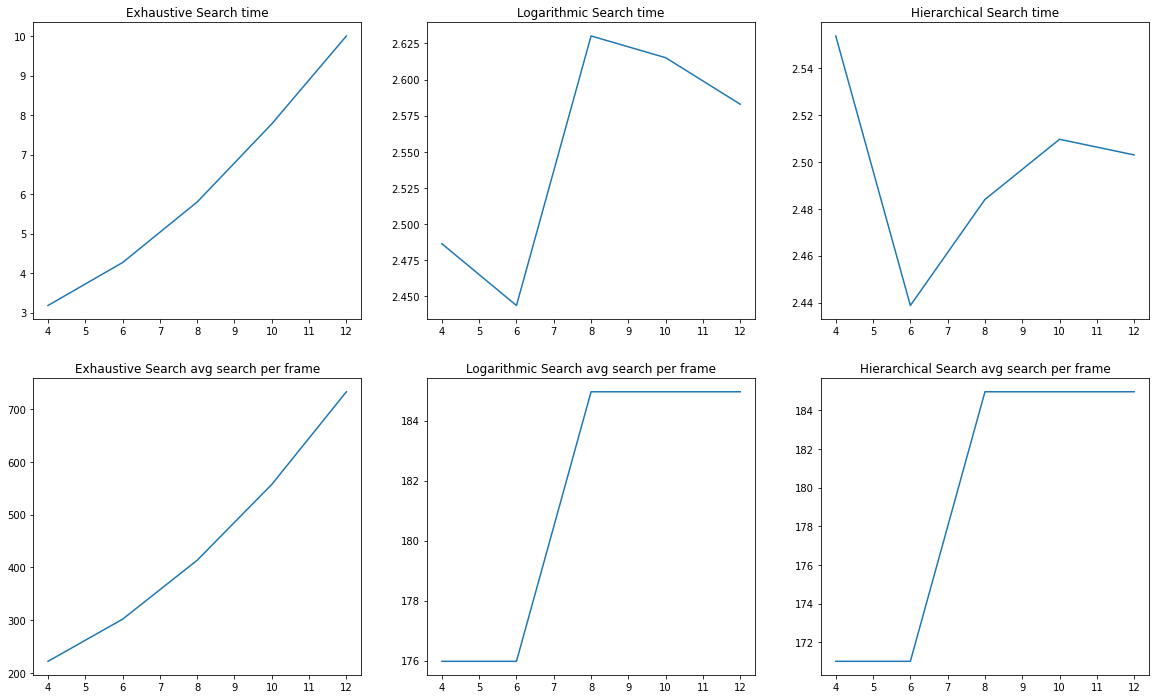

In [76]:
# show plot side by side
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,12))

ax[0,0].plot(P,exhaustive_time)
ax[0,0].set_title('Exhaustive Search time')

ax[0,1].plot(P,logarithmic_time)
ax[0,1].set_title('Logarithmic Search time')

ax[0,2].plot(P,hierarchical_time)
ax[0,2].set_title('Hierarchical Search time')

ax[1,0].plot(P,exhaustive_avg_search)
ax[1,0].set_title('Exhaustive Search avg search per frame')

ax[1,1].plot(P,logarithmic_avg_search)
ax[1,1].set_title('Logarithmic Search avg search per frame')

ax[1,2].plot(P,hierarchical_avg_search)
ax[1,2].set_title('Hierarchical Search avg search per frame')



